### Setting up FourRooms

In [1]:

import sys,os
import matplotlib.pyplot as plt
sys.path.append('../')
from deep_rl.component.fourrooms import *

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
from gym_minigrid.wrappers import *
env = gym.make('MiniGrid-Empty-8x8-v0')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
obs = env.reset() # This now produces an RGB tensor only
env = TransposeImage(env)

NameError: name 'TransposeImage' is not defined

In [10]:
obs.shape

(64, 64, 3)

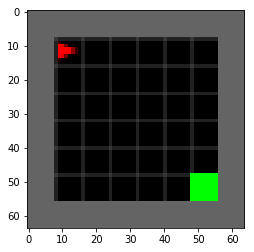

In [7]:
plt.imshow(obs)

### Run DQN on 4 rooms

In [3]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [4]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(43,)))
    config.network_fn = lambda: VanillaNet(config.action_dim, NatureConvBody(in_channels=3))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [31]:
class NatureConvBody(nn.Module):
    def __init__(self, in_channels=4):
        super(NatureConvBody, self).__init__()
        self.feature_dim = 512
        self.conv1 = layer_init(nn.Conv2d(in_channels, 32, kernel_size=3, stride=2))
        self.conv2 = layer_init(nn.Conv2d(32, 64, kernel_size=3, stride=2))
#         self.conv3 = layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=2))
        self.fc4 = layer_init(nn.Linear(9 * 9 * 64, self.feature_dim))

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
#         y = F.relu(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc4(y))
        return y

In [32]:
game = 'MiniGrid-Empty-5x5-v0'
agent = dqn_feature(game=game)

2020-07-16 04:27:44,932 - root - INFO: steps 0, episodic_return_test 0.00(0.00)


KeyboardInterrupt: 

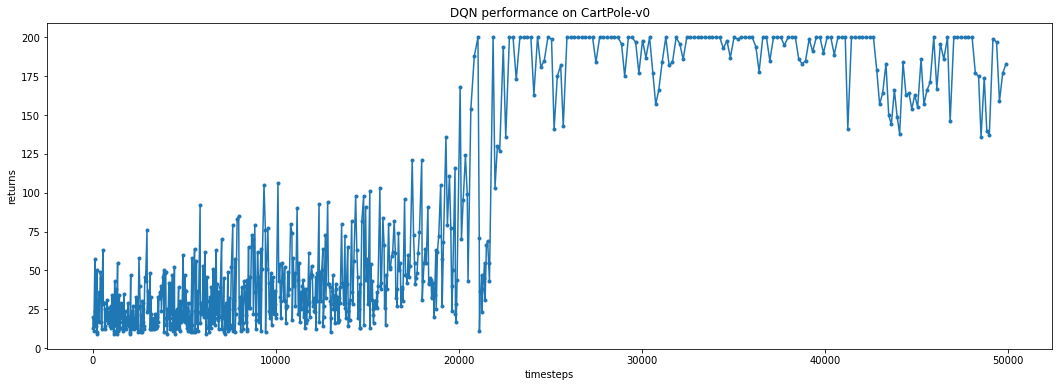

(Text(0.5, 1.0, 'DQN performance on CartPole-v0'), None)

In [8]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [15]:
class SRNetWithReconstruction(nn.Module):
    def __init__(self, output_dim, body, hidden_units_sr=(64,), hidden_units_rec=(16,), hidden_units_psi2q=(), gate=F.relu, config=1):
        """
        This network has two heads: SR head (SR) and reconstruction head (rec).
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetWithReconstruction, self).__init__()
        self.body = body
        self.output_dim = output_dim
        self.gate = gate

        dims_sr = (body.feature_dim,) + hidden_units_sr + (body.feature_dim * output_dim,)
        dims_rec = (body.feature_dim,) + hidden_units_rec + (body.state_dim,) # this doesn't work for conv layers

        # layers for SR
        self.layers_sr = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims_sr[:-1], dims_sr[1:])])
        
        # layers for reconstruction
        self.layers_rec = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims_rec[:-1], dims_rec[1:])])

        # SR final head layer
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, body.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, body.feature_dim, hidden_units=hidden_units_psi2q)

    def forward(self, x):

        # Finding the latent layer
        phi = self.body(tensor(x)) # shape: b x state_dim

        # Estimating the SR from the latent layer
        psi = phi
        for layer in self.layers_sr[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers_sr[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        q_est = self.psi2q(psi)

        # Reconstructing the state from the latent layer    
        k = phi
        for layer in self.layers_rec[:-1]:
            k = self.gate(layer(k))
        state_est = self.layers_rec[-1](k)


        return phi, psi, state_est, q_est

In [10]:
class avDSRAgent_v2(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_rec_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.choice = config.choice
        self.actor = avDSRActor_v2(config, agents, style, self.choice)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _, _ = self.network(next_states)

            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            phi, psi, state_rec, _ = self.network(states)
            psi_next.add_(phi) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            psi = psi[self.batch_indices, actions, :]
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            # Estimating reconstuction loss
            loss_rec = (state_rec - tensor(states)).pow(2).mul(0.5).mean()
            loss = loss_psi + config.c * loss_rec
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(loss_psi.item())
            self.loss_rec_vec.append(loss_rec.item())
            
            
            self.optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()

In [36]:
def avdsr_feature_v2(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = .00005

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.0005)
    config.network_fn = lambda: SRNetWithReconstruction(config.action_dim, 
                                                        FCBody(config.state_dim, hidden_units=(16,64))
                                                        ,config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(2e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 3e4
    config.async_actor = False
    
    agent = avDSRAgent_v2(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [37]:
avdsr = avdsr_feature_v2(game='CartPole-v0', agents=[agent], choice=0)

2020-06-12 00:45:50,489 - root - INFO: steps 0, 381300363.64 steps/s
2020-06-12 00:45:51,443 - root - INFO: steps 1000, 1053.14 steps/s
2020-06-12 00:45:52,387 - root - INFO: steps 2000, 1059.56 steps/s
2020-06-12 00:45:53,334 - root - INFO: steps 3000, 1056.72 steps/s
2020-06-12 00:45:54,281 - root - INFO: steps 4000, 1056.86 steps/s
2020-06-12 00:45:55,225 - root - INFO: steps 5000, 1061.19 steps/s
2020-06-12 00:45:56,180 - root - INFO: steps 6000, 1047.97 steps/s
2020-06-12 00:45:57,124 - root - INFO: steps 7000, 1059.85 steps/s
2020-06-12 00:45:58,077 - root - INFO: steps 8000, 1057.72 steps/s
2020-06-12 00:45:59,021 - root - INFO: steps 9000, 1060.43 steps/s
2020-06-12 00:45:59,965 - root - INFO: steps 10000, 1060.34 steps/s
2020-06-12 00:46:00,917 - root - INFO: steps 11000, 1050.70 steps/s
2020-06-12 00:46:01,864 - root - INFO: steps 12000, 1057.92 steps/s
2020-06-12 00:46:02,809 - root - INFO: steps 13000, 1058.23 steps/s
2020-06-12 00:46:03,759 - root - INFO: steps 14000, 1053

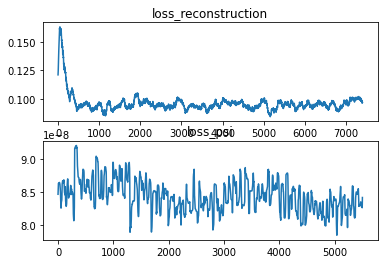

In [45]:
plt.subplot(211), plt.plot(convolve(avdsr.loss_rec_vec,100)), plt.title('loss_reconstruction')
plt.subplot(212), plt.plot(convolve(avdsr.loss_psi_vec,1000)[1000:]), plt.title('loss_psi')
plt.show()

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [17]:
class DSRActor_v2(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, _, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent_v2(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor_v2(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, _, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            if(config.freeze == 1):
                # Update all based on loss_psi
                self.optimizer.zero_grad()
                loss_psi.backward(retain_graph=True)
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
                with config.lock:
                    self.optimizer.step()
                    
                # Update only w parameters based on loss_q
                self.w_optimizer.zero_grad()
                loss_q.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
                with config.lock:
                    self.w_optimizer.step()
            elif(config.freeze == 2):
                # Update only w parameters based on loss_q
                self.w_optimizer.zero_grad()
                loss_q.backward()
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
                with config.lock:
                    self.w_optimizer.step()
            else: # freeze = 0
                 # Update all params based on whole loss
                self.optimizer.zero_grad()
                loss.backward(retain_graph=True)
                nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
                with config.lock:
                    self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

In [33]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNetWithReconstruction(config.action_dim, 
                                                        FCBody(config.state_dim, hidden_units=(16,64)),
                                                        hidden_units_psi2q=(100,50),
                                                        config=1) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent_v2(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [34]:
def runNAgents(function, runs, store=True, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='CartPole-v0', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [39]:
r_c0 = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
# r_c1 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr)
# r_dqn_base_16 = runNAgents(dqn_feature, runs=3)
# r_dqn_base_676 = runNAgents(dqn_feature, runs=1)

/network/home/penmetss/.conda/envs/default/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
2020-06-12 00:46:35,794 - root - INFO: steps 0, episodic_return_test 9.00(0.20)


IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias', 'psi2q.layers.1.weight', 'psi2q.layers.1.bias', 'psi2q.layers.2.weight', 'psi2q.layers.2.bias'], unexpected_keys=['psi2q.w'])


2020-06-12 00:46:43,305 - root - INFO: steps 5000, episodic_return_test 9.70(0.20)
2020-06-12 00:46:50,790 - root - INFO: steps 10000, episodic_return_test 9.50(0.16)
2020-06-12 00:46:58,265 - root - INFO: steps 15000, episodic_return_test 9.50(0.21)
2020-06-12 00:47:05,712 - root - INFO: steps 20000, episodic_return_test 9.40(0.25)
2020-06-12 00:47:13,139 - root - INFO: steps 25000, episodic_return_test 9.40(0.29)
2020-06-12 00:47:20,548 - root - INFO: steps 30000, episodic_return_test 10.00(0.14)
2020-06-12 00:47:28,113 - root - INFO: steps 35000, episodic_return_test 9.60(0.29)
2020-06-12 00:47:35,687 - root - INFO: steps 40000, episodic_return_test 9.50(0.16)
2020-06-12 00:47:43,083 - root - INFO: steps 45000, episodic_return_test 9.10(0.17)
2020-06-12 00:47:50,467 - root - INFO: steps 50000, episodic_return_test 9.10(0.26)


In [235]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 500
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

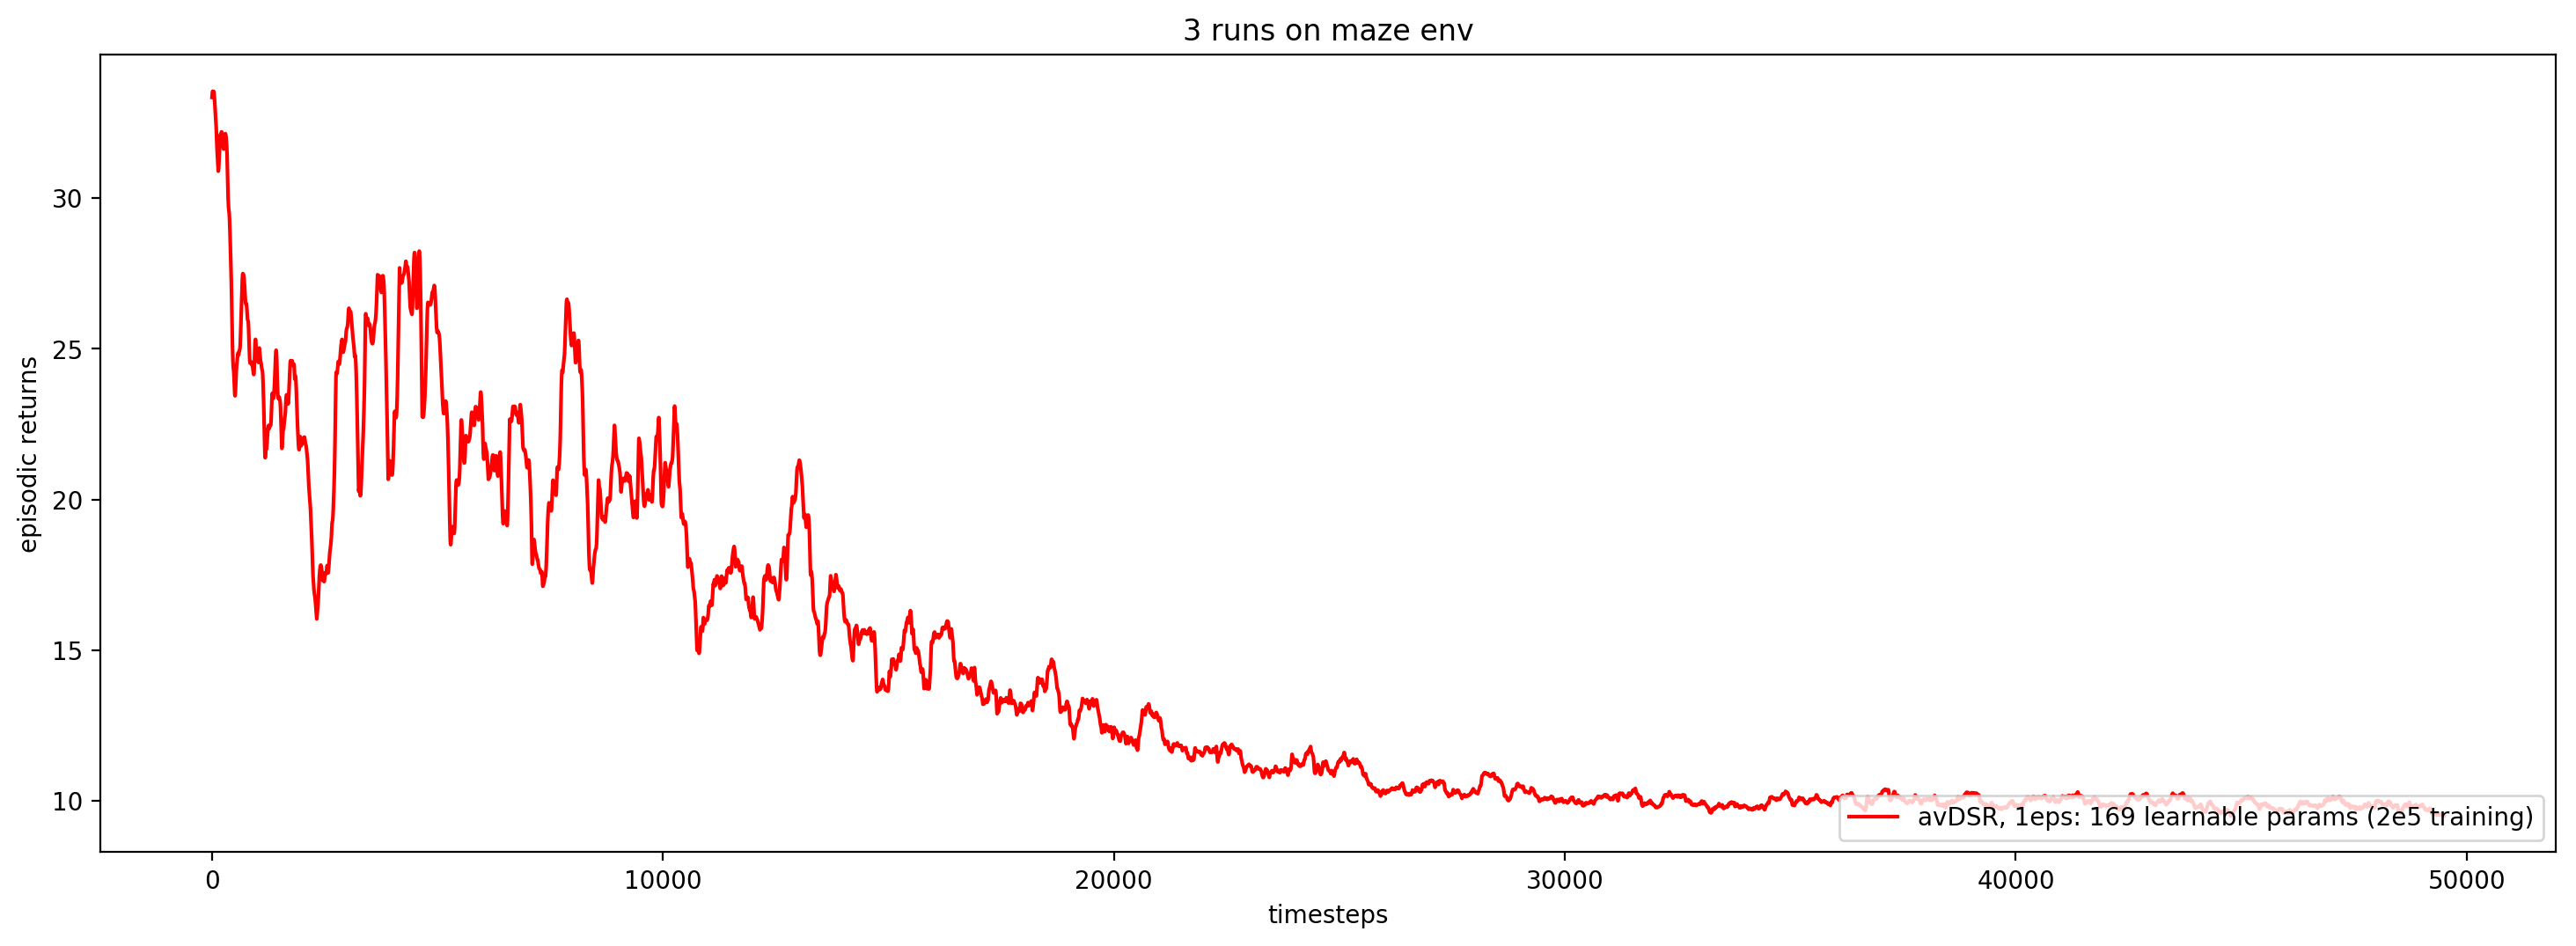

In [236]:
rewards_dict = {
#                 'DQN, h=(16,): 2788 learnable params': r_dqn_base_16[1:],
#                'DQN, h=(676,): 117628 learnable params': r_dqn_base_676[1:],
               'avDSR, 1eps: 169 learnable params (2e5 training)': r_c0[1:],
#                'avDSR, 1eps: 2708 learnable params (2e5 training)': r_c1[1:]
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='3 runs on maze env')

In [ ]:
import pickle
    
# with open('storage/rewards.pickle', 'wb') as f:
#     pickle.dump(rewards_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('storage/rewards.pickle', 'rb') as f:
    rewards = pickle.load(f)

r_dsr_rand = rewards['avDSR, 1eps: 169 learnable params']
r_dqn_base = rewards['DQN, h=(676,): 117628 learnable params']

### ROUGH BELOW

In [ ]:
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.

Modified to return one hot encoded states and gym compatible.

"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRoomsMatrix(gym.Env):

    def __init__(self, goal=62, p=0, config=2):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}


        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True):
        current_grid = np.array(self.occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        state = self.rng.choice(self.init_states)
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            self.updates = 0
            return temp
        elif(self.config == 2):
            return env.render()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return env.render, reward, done, {}

        